# Notebook 5: Gaussian mixture models
***

In this notebook we'll try our hand and generating data from a Gaussian mixture model, as well as fitting a GMM to some data in a not-very-rigorous way. Then, next time, we will use the expectation-maximization (EM) algorithm to fit our GMM in a very rigorous and highly satisfying way.

We'll need some nice packages for this notebook, so let's load them.

In [1]:
import numpy as np 
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

<br>

### Exercise 1:  Generating a Gaussian mixture

A Gaussian mixture model (GMM) is a statistical model to describe some phenomena as composed from ***components*** that each follow a Gaussian, or normal, distribution. The probability of observing random variable $X=x$, if $X$ follows a normal distribution with mean $\mu$ and variance $\sigma^2$ is
$$Pr(X=x \mid \mu, \sigma^2) = \phi(x \mid \mu, \sigma^2),$$

where $\phi$ denotes a normal probability density function with parameters $\mu$ and $\sigma^2$. The probability of observing $X=x$ is *conditioned* on the statistical model's parameters, which are the parameters of this normal distribution.

If the distribution of $X$ is instead a *mixture of two Gaussians*, with means $\mu_1$ and $\mu_2$, and variances $\sigma^2_1$ and $\sigma^2_2$, then the probability of observing $X=x$ given the model parameters (the $\mu$s and $\sigma^2$s) is
$$Pr(X=x \mid \mu_1, \mu_2, \sigma^2_1, \sigma^2_2, \pi) = (1-\pi) \phi(x \mid \mu_1, \sigma^2_1) + \pi \phi(x \mid \mu_2, \sigma^2_2).$$

Here, $\pi$ is a new parameter that represents the balance between the two components. Since there are now 5 parameters of our statistical model to keep track of, we typically bundle them all up in a parameters vector, often called $\theta = (\pi, \mu_1, \mu_2, \sigma^2_1, \sigma^2_2)$.

**Consider:** what happens if $\pi = 1$? What about if $\pi=0$?

Let's suppose we want to sample from a GMM with the following parameters:
* $\mu_1 = 3$, $\sigma^2_1 = 1$
* $\mu_2 = 8$, $\sigma^2_2 = 2$
* $\pi = 0.75$

In [2]:
mu1, var1 = 3, 1
mu2, var2 = 8, 2
pi = 0.75

**Before we continue**, make a sketch by hand of each of the component normal distributions, and what you hypothesize their mixture should look like with equal weights ($\pi = 0.5$). If you aren't sure, argue loudly with those around you until everyone is firmly emotionally invested in their guesses.

Are you invested yet?

Good.

We can consider a **generative** model for drawing a sample from a GMM as a pair of steps. 

**First**, draw $\Delta \sim Ber(\pi)$.

In [3]:
np.random.seed(4022)
delta = np.random.choice([0,1], p=[1-pi, pi])
print(delta)

1


**Then**, if $\Delta=1$, we draw $X$ from $N(\mu_2, \sigma^2_2)$. If $\Delta=0$, we draw $X$ from $N(\mu_1, \sigma^2_1)$.

Here, our $\Delta = 1$ so we draw our sample from $N(\mu_2, \sigma^2_2)$.

In [4]:
x = stats.norm.rvs(loc=mu2, scale=np.sqrt(var2))
print(x)

9.510577844757728


Finish off the code below for a function to generate a sample from a GMM. Places where your help is needed are marked with a TODO.

In [5]:
def gmm_samples(num_samples, mu1, var1, mu2, var2, pi):
    samples = []
    for k in range(num_samples):
        # Sample Delta ~ Bernoulli(pi)
        delta = 0 # TODO
        # Sample from the appropriate normal distribution
        if ___: # TODO
            samples.append(___) # TODO
        else:
            samples.append(___) # TODO
    return samples

Use the `gmm_samples` function to generate a sample of size 10,000 from the GMM with the parameters given above.

In [6]:
sample = 0 # TODO

Run the cell below to generate a density histogram of the resulting distribution of samples from our GMM. Does the figure match what you expected?

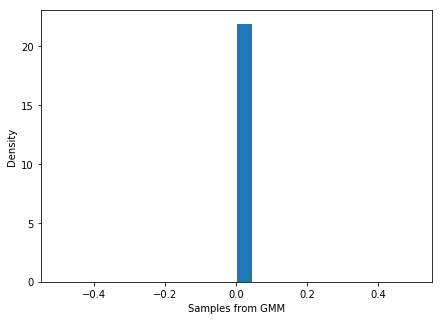

In [7]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
plt.hist(sample, edgecolor="white", density=True, bins=22)
plt.xlabel("Samples from GMM")
plt.ylabel("Density")
plt.show()

<br>

### Exercise 2: Hand-tuning a GMM

<img width=400px src="https://www.grossmontcenter.com/wp-content/uploads/bigstock-Chuck-E-Cheese-s-Store-Mouse-92876894.jpg">

Read in the data file `ages.csv`, which corresponds to the Chuck E. Cheese's age data that you collected before getting banned from the chain of American family entertainment centers and restaurants.

In [8]:
dfA = pd.read_csv("../data/ages.csv", header=None)

Start by plotting up a density histogram of the data, including appropriate axis labels. Make the box face color purple to match Chuck's shirt and hat. Use 20 bins in order to best match the plots we saw in class.

The parameters from the last lecture slide are as follows:

In [9]:
mu1, mu2 = 10, 38
var1, var2 = 7, 20
pi = 0.50

Let's lay down a grid of $x$ (age) coordinates so we can superimpose on the age data the GMM defined by those parameters.

In [10]:
xgrid = np.linspace(0,60,200)

We can evaluate the normal probability density function for each component as:

In [11]:
# pdf from component 1
f1 = stats.norm.pdf(xgrid, loc=mu1, scale=np.sqrt(var1))
# pdf from component 2
f2 = stats.norm.pdf(xgrid, loc=mu2, scale=np.sqrt(var2))

And we can combine them into a Gaussian mixture by weighting each by $w_1 = 1-\pi$ and $w_2 = \pi$. The result *is* the probability density estimate defined by our parameters above.

In [12]:
fmix = (1-pi)*f1 + pi*f2

Add `fmix` to the histogram from above.

Now, we could adjust the 5 parameters $\theta = (\pi, \mu_1, \mu_2, \sigma_1^2, \sigma_2^2)$ until the plot looks good to our eyes. But that's imprecise, tedious and doesn't scale up well to problems with more dimensions (so the means and variances have more values to estimate) or with more components in the mixture (so there are more means and variances). If only there were some *function* we could use in order to quantify how *likely* our set of parameters is...!

Luckily, there is! The likelihood function is the probability we saw earlier in the slides and the top of this notebook:

$$Pr(X=x \mid \theta) = (1-\pi) \phi(x \mid \mu_1, \sigma^2_1) + \pi \phi(x \mid \mu_2, \sigma^2_2)$$

(where $\theta$ is used as shorthand for all five parameters)

Define the likelihood function as an actual Python function. It should take as input arguments a data point $x$, and all 5 of the statistical parameters ($\pi, \mu_1, \mu_2, \sigma_1^2, \sigma_2^2$), and yield as an output a single probability of observing that data point, given those parameter values.

In [13]:
def likelihood(x, mu1, mu2, var1, var2, pi):
    # your code goes here!
    return 0 # ... and here!

We can evaluate the likelihood function for a single data point as:

In [14]:
likelihood(dfA[0][0], mu1, mu2, var1, var2, pi)

0

Now, that's just the likelihood function for a single data point. We need to multiply them all together in order to obtain the full ***joint likelihood*** for all 54 of our data points from the age data set.

$$\begin{align*} Pr(\vec{x} \mid \theta) &= \prod_{i=1}^{54} Pr(x_i \mid \theta) \\
      &= \prod_{i=1}^{54} [(1-\pi) \phi(x_i \mid \mu_1, \sigma^2_1) + \pi \phi(x_i \mid \mu_2, \sigma^2_2)]
      \end{align*}$$

So we need to evaluate the likelihood function for *all* our data points, and take the product to obtain the joint likelihood.

In [15]:
np.prod([likelihood(dfA[0][k], mu1, mu2, var1, var2, pi) for k in range(len(dfA))])

0

Yowza! That is a seriously small number. To avoid numerical issues and underflow, we typically use the **log-likelihood** function instead:

$$\begin{align*} l(\vec{x} \mid \theta) &= \log{Pr(\vec{x} \mid \theta)} \\
      &= \log{\left(\prod_{i=1}^{54} Pr(x_i \mid \theta)\right)} \\
      &= \sum_{i=1}^{54} \log\left[(1-\pi) \phi(x_i \mid \mu_1, \sigma^2_1) + \pi \phi(x_i \mid \mu_2, \sigma^2_2)\right]
      \end{align*}$$

Define a new function called `log_likelihood` to return the log-likelihood of a single data point.

In [16]:
def log_likelihood(x, mu1, mu2, var1, var2, pi):
    # your code goes here!
    return 0 # ... and here!

Check to make sure the natural log of the likelihood of the first data point actually is equal to your log-likelihood function's output for that data point.

In [17]:
# SOLUTION:


Finally, we can evaluate the joint log-likelihood for our data set:

In [18]:
def joint_log_likelihood(df, mu1, mu2, var1, var2, pi):
    return np.sum([likelihood(df[0][k], mu1, mu2, var1, var2, pi) for k in range(len(df))])

In [19]:
joint_log_likelihood(dfA, mu1, mu2, var1, var2, pi)

0

Well now! That's a much more reasonable number. Long live the log-likelihood!

See if you can fiddle with the 5 parameters in order to increase the value of the log-likelihood. There are lots of rigorous approaches to this, one of which we'll tackle next time - the EM algorithm. But for now, just get a feel for how changing the different parameters changes the goodness of fit of our Gaussian mixture model.

In [20]:
mu1, mu2 = 10, 38
var1, var2 = 7, 20
pi = 0.50
joint_log_likelihood(dfA, mu1, mu2, var1, var2, pi)

0

<br>

### Exercise 3: Plotting contours and density estimates

Above, we saw how we can plot our Gaussian mixture model probability density estimate for a mixture of two Gaussians. Plotting for a 3-component model in 1-dimension is a fairly straightforward extension of that.

But what about plotting up a Gaussian mixture in 2-dimensional space? Suppose instead we have a Gaussian mixture model with means $\vec{\mu}_1 = (3,3)$ and $\vec{\mu}_2 = (6,6)$. In 2 dimensions, the variances are now replaced by a 2-by-2 ***covariance*** matrix. Recall that the diagonal elements of the covariance matrix correspond to the variances in each of the primary directions, while the off-diagonal elements correspond to correlations. Here, we are defining a two-component GMM where each component's $x$ and $y$ coordinates are independent (off-diagonals are 0):

In [27]:
# Parameters to set
mu1 = [3,3]
covar1 = [[1,0],[0,1]]
mu2 = [6,6]
covar2 = [[2,0],[0,2]]
pi = 0.75

In order to make a visualization of this mixture model, we need to visualize in both dimensions. So we need to lay down a grid of coordinates in $x$ and $y$, at 200 points between 0 and 10 in each direction:

In [22]:
# Grid of evenly spaced coordinates in x and y directions
x = np.linspace(0,10,200)
y = np.linspace(0,10,200)
X,Y = np.meshgrid(x,y)

If you aren't sure what this code chunk has done, have a look at the man page for `meshgrid` and check out what has ended up in the `X` and `Y` arrays.

Now we can evaluate each of the two components of our mixture model at the coordinates stored in `X` and `Y`.

In [23]:
# Evaluate each component at the coordinates in X and Y
f1 = np.zeros(X.shape)
f2 = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        f1[i,j] = stats.multivariate_normal.pdf(x=(X[i,j],Y[i,j]), mean=mu1, cov=covar1)
        f2[i,j] = stats.multivariate_normal.pdf(x=(X[i,j],Y[i,j]), mean=mu2, cov=covar2)

And finally mix the two components together using the mixture weighting parameter $\pi$.

In [24]:
fmix = (1-pi)*f1 + pi*f2

Run the code block below to create a basic contour plot to visualize the mixture model. You can find a menu of different colormaps for Matplotlib [here](https://scipy-cookbook.readthedocs.io/_downloads/colormaps3.png), and feel free to tool around with the different contour plot options in Matplotlib.

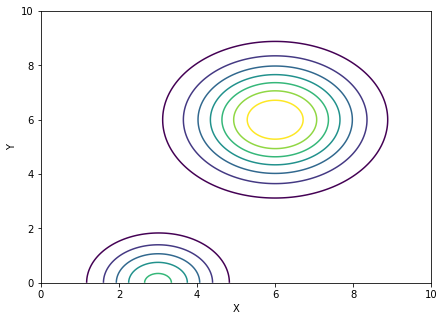

In [25]:
my_levels = np.arange(0, 0.0675, 0.0075)

fig, ax = plt.subplots(1,1, figsize=(7,5))
cp = ax.contour(X, Y, fmix, levels=my_levels)
#norm = plt.colors.Normalize(vmin=0, vmax=0.06)
#sm = plt.cm.ScalarMappable(norm=norm, cmap = cp.cmap)
#sm.set_array([])
#fig.colorbar(sm, ax=ax, pad=0.05, shrink=0.9, drawedges=True)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

Now let's play around with the off-diagonal elements (the correlations) in the covariance matrices for each of the mixture components. Change the off-diagonal elements to be values besides 0, and re-run the evaluation and plotting code below to see what the impacts are on the model.

**Note:** When you are changing the covariance matrices, remember that a covariance matrix must be symmetric.

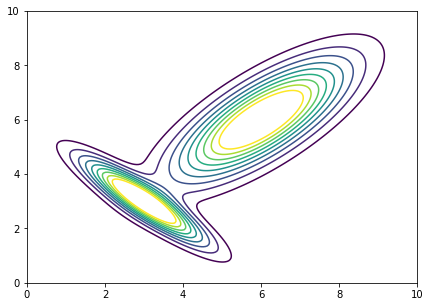

In [26]:
# Parameters to set
mu1 = [3,3]
covar1 = [[1,-.9],[-.9,1]]   # TODO - change the off-diagonal elements
mu2 = [6,6]
covar2 = [[2,1.5],[1.5,2]]   # TODO - change the off-diagonal elements
pi = 0.75

# Evaluate each component at the coordinates in X and Y
f1 = np.zeros(X.shape)
f2 = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        f1[i,j] = stats.multivariate_normal.pdf(x=(X[i,j],Y[i,j]), mean=mu1, cov=covar1)
        f2[i,j] = stats.multivariate_normal.pdf(x=(X[i,j],Y[i,j]), mean=mu2, cov=covar2)
fmix = (1-pi)*f1 + pi*f2        
my_levels = np.arange(0, 0.0675, 0.0075)

fig, ax = plt.subplots(1,1, figsize=(7,5))
cp = ax.contour(X, Y, fmix, levels=my_levels)
#norm = plt.colors.Normalize(vmin=0, vmax=0.06)
#sm = plt.cm.ScalarMappable(norm=norm, cmap = cp.cmap)
#sm.set_array([])
#fig.colorbar(sm, ax=ax, pad=0.05, shrink=0.9, drawedges=True)
#plt.xlabel("X")
#plt.ylabel("Y")
plt.show()